In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy
import scipy.stats
from scipy.optimize import basinhopping

import itertools

from distfit import distfit

In [2]:
class GSTARThresholdClassifier:
    def __init__(self, estimator, l=1.0, niter=10, verbose=False):
        self.estimator = estimator
        self.l = l
        self.niter = niter
        self.verbose = verbose
        
        self.best_thresholds_ = None        
                         
    def fit(self, X, y, sensitive_attr):
        '''
        X -> numpy array
        y -> numpy array
        sensitive_attr -> numpy array
        '''
        self.X_ = X
        self.y_ = y
        self.groups_ = list(np.unique(sensitive_attr))
        
        scores = self.estimator.predict_proba(self.X_)[:,1]
        
        f = lambda x: self._get_loss(scores, sensitive_attr, eval(self._generate_lambda_func_str()))
        bounds = tuple((0,1) for i in range(len(self.groups_)))
        minimizer_kwargs = {"method": "BFGS", "jac": False, "bounds": bounds}
        init_thresholds = np.random.uniform(0,1,len(self.groups_)) #
        ret = basinhopping(f, init_thresholds, minimizer_kwargs=minimizer_kwargs, niter=self.niter)
        
        self.best_thresholds_ = ret.x
        self.best_loss_ = ret.fun
        
        return self.best_thresholds_, self.best_loss_

    def predict(self, X, sensitive_attr):
        # TODO: check_is_fitted()
        threshold_arr = np.zeros_like(sensitive_attr)
        for key, val in (zip(self.groups_, self.best_thresholds_)):
            threshold_arr[sensitive_attr == key] = val
        
        scores = self.estimator.predict_proba(X)[:,1]
        y_pred = np.where(scores > threshold_arr, 1, 0)

        return y_pred

    def plot(self):
        # TODO: check_is_fitted()
        scores = self.estimator.predict_proba(self.X_)[:,1]
        
        p_mask = self.y_.astype(bool)
        n_mask = (1-self.y_).astype(bool)
        
        colors = cm.rainbow(np.linspace(0, 1, len(self.groups_)))
        fig, (ax_y_0, ax_y_1) = plt.subplots(2, 1, sharex=True)
        
        for i, true_mask in enumerate([p_mask,n_mask]):
            if i == 0:
                axis = ax_y_0
                axis.set_title('$Y = 0$')
            if i == 1:
                axis = ax_y_1
                axis.set_title('$Y = 1$')
            
            for j, g in enumerate(self.groups_):
                axis.hist(scores[(true_mask)&(self.group_masks_[g])], alpha=0.5, color=colors[j],label=g)
                axis.axvline(x = self.best_thresholds_[j], linestyle='--', color=colors[j],label=f'Threshold: {g}')
        
            axis.axvline(x = 0.5, linestyle='--', color='grey', label="Original threshold")
            axis.set_xlim(0,1)
            axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        fig.tight_layout()
        fig.show()

    def _get_loss(self, scores, sensitive_attr, thresholds):
        f_0_gs, f_1_gs = self._fit_dists(scores,sensitive_attr)
        confusion_matrices = {}
        for i, g in enumerate(self.groups_):
            confusion_matrices[g] = self._get_confusion_matrix(f_0_gs, f_1_gs, g, thresholds[i])

        # Loss perf
        N = len(sensitive_attr)
        loss_perf = 0
        for g in self.groups_:
            n = sum(np.where(sensitive_attr == g, 1, 0))
            loss_perf += (n/N) * confusion_matrices[g]['fp'] + (n/N) * confusion_matrices[g]['fn']
            
        loss_perf = loss_perf**2

        # Loss EOd
        loss_eod = 0
        for comb in itertools.combinations(self.groups_, 2):
            loss_eod += (confusion_matrices[comb[0]]['tp'] - confusion_matrices[comb[1]]['tp'])**2
            loss_eod += (confusion_matrices[comb[0]]['fp'] - confusion_matrices[comb[1]]['fp'])**2

        loss = loss_perf + (self.l * loss_eod)

        if self.verbose:
            print(f"DEBUG::loss:{loss}")

        return loss

    def _get_confusion_matrix(self, f_0_gs, f_1_gs, group, threshold):
        tp = 1 - f_1_gs[group].cdf(threshold)
        fp = 1 - f_0_gs[group].cdf(threshold)
        fn = 1 - tp
        tn = 1 - fp
        return {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

    def _fit_dists(self, scores, sensitive_attr):
        
        group_masks = self._get_group_masks(sensitive_attr)
        p_mask = self.y_.astype(bool)
        n_mask = (1-self.y_).astype(bool)
        
        f_0_gs = {}
        f_1_gs = {}
        
        for g in group_masks.keys():
            dfit_p, dfit_n = distfit(distr='gamma',verbose=False), distfit(distr='gamma',verbose=False)
            dfit_p.fit_transform(scores[(p_mask)&(group_masks[g])])
            dfit_n.fit_transform(scores[(n_mask)&(group_masks[g])])
            f_0_gs[g], f_1_gs[g] = dfit_n.model['model'], dfit_p.model['model']

        self.f_0_gs = f_0_gs
        self.f_1_gs = f_1_gs
        
        return f_0_gs, f_1_gs
        
    def _get_group_masks(self, sensitive_attr):
        group_masks = {}
        for g in self.groups_:
            group_masks[g] = np.where(sensitive_attr == g, 1, 0).astype(bool)
            
        self.group_masks_ = group_masks
        return group_masks

    def _generate_lambda_func_str(self):
        '''
        This function is necessary due to pecularities in the basinhoppin setup
        '''
        lambda_func_str = '['
        for i in range(0,len(self.groups_)):
            lambda_func_str += f'x[{i}],'
        lambda_func_str = lambda_func_str[:-1] + ']'
        
        return lambda_func_str

In [3]:
heart_disease = fetch_ucirepo(id=45) 
  
X = heart_disease.data.features 
y = heart_disease.data.targets.to_numpy().flatten()
y = np.where(y>1,1,0)

In [4]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp_mean.fit_transform(X)

In [5]:
clf = LogisticRegression(random_state=0,solver='liblinear',C=10e-2).fit(X, y.flatten())
clf.score(X,y)

0.8613861386138614

In [6]:
gstar = GSTARThresholdClassifier(clf,l=1.0,niter=10,verbose=True)
gstar.fit(X,y,X[:,1])

DEBUG::loss:0.261805238873711
DEBUG::loss:0.2618052061715056
DEBUG::loss:0.2618052613920412
DEBUG::loss:2.6292329054874672
DEBUG::loss:2.6292329377895296
DEBUG::loss:2.629232905402337
DEBUG::loss:0.08816583345825804
DEBUG::loss:0.08816583100252949
DEBUG::loss:0.08816584147070224
DEBUG::loss:0.9640508749861423
DEBUG::loss:0.964050914774072
DEBUG::loss:0.9640508758327466
DEBUG::loss:0.08330226893897694
DEBUG::loss:0.08330226659270842
DEBUG::loss:0.083302275856912
DEBUG::loss:0.07517875385714395
DEBUG::loss:0.07517875188888976
DEBUG::loss:0.07517875851443656
DEBUG::loss:0.06825734761789641
DEBUG::loss:0.0682573467695371
DEBUG::loss:0.06825734801559366
DEBUG::loss:0.06801307188579125
DEBUG::loss:0.0680130712869754
DEBUG::loss:0.06801307193588668
DEBUG::loss:0.06767737565775452
DEBUG::loss:0.06767737544316356
DEBUG::loss:0.06767737546187877
DEBUG::loss:0.06755307799788926
DEBUG::loss:0.06755307793822096
DEBUG::loss:0.06755307790020325
DEBUG::loss:0.06753437665389767
DEBUG::loss:0.0675343766

(array([0.23082153, 0.30858969]), np.float64(0.06753389200717995))

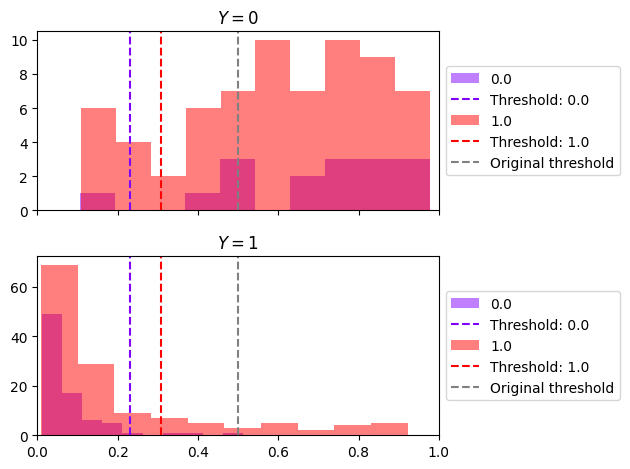

In [7]:
gstar.plot()